# 4. DNN model 생성
- 비 선형적인 관계를 잘 표현할 수 있는 DNN모델 사용

In [4]:
#import torch
import pandas as pd
import numpy as np
import seaborn as sns

In [5]:
#data_noname = pd.read_csv('data/train_set/3.data_normalize2_noname.csv')
#data = pd.read_csv('data/train_set/3.data_normalize_merged.csv')
# data = pd.read_csv('temp2_imputation_after.csv', index_col = 0)
data = pd.read_csv('data/train_set/3.data_normalize2.csv')
data.loc[1]
len(data)
plt.boxplot(data['buy_count'].dropna())

FileNotFoundError: [Errno 2] File b'data/train_set/3.data_normalize.csv' does not exist: b'data/train_set/3.data_normalize.csv'

In [329]:
train_len = int(len(data['buy_count'].dropna()))
outlier = data.sort_values("buy_count",ascending= False).index[:int(train_len*0.1)]

In [330]:
data = data.drop(index = outlier).reset_index(drop = True)

In [331]:
len(data)

32660

{'whiskers': [<matplotlib.lines.Line2D at 0x24d3951f708>,
 'caps': [<matplotlib.lines.Line2D at 0x24d3951fd88>,
 'boxes': [<matplotlib.lines.Line2D at 0x24d39517f48>],
 'medians': [<matplotlib.lines.Line2D at 0x24d39525d08>],
 'fliers': [<matplotlib.lines.Line2D at 0x24d39525e08>],
 'means': []}

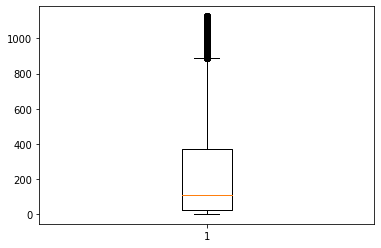

In [308]:
plt.boxplot(data['buy_count'].dropna())

In [332]:
#x_data = data.drop(columns = ['buyer_count_CaAvgdiff','pastAvg_diff', 'handling_amount', 'buy_count'])
# x_data = data.drop(columns = ['max_watching','avg_watching','buy_count','buyer_count_CaAvgdiff','pastBuyer_count_diff','merged_diff'])
x_data = data.drop(columns = ['diff','buy_count','unit_price','pastBuyer_count_mean_org'])
y_data = data[['diff','type']]

In [333]:
x_data.loc[:,'off_day'] = x_data.loc[:,'off_day'].astype('float64')
x_data.loc[:,'pmWarning_busan']= x_data.loc[:,'pmWarning_busan'].astype('float64')
x_data.loc[:,'pmWarning_seoul']= x_data.loc[:,'pmWarning_seoul'].astype('float64')
x_data.loc[:,'working_time']= x_data.loc[:,'working_time'].astype('float64')


In [334]:
# from sklearn.model_selection import train_test_split
# train_x, testvalid_x, train_y, testvalid_y = train_test_split(x_data, y_data, test_size = 0.2, random_state = 1)
# test_x, valid_x, test_y, valid_y = train_test_split(testvalid_x, testvalid_y, test_size = 0.5, random_state = 1)
# 29770
# 32477
train_x = x_data.loc[x_data.type == 'train'].drop(columns = 'type').loc[0:int(len(x_data)*0.8)]
valid_x = x_data.loc[x_data.type == 'train'].drop(columns = 'type').loc[int(len(x_data)*0.8):]
test_x =x_data.loc[x_data.type == 'test'].drop(columns = 'type')

train_y= y_data.loc[y_data.type == 'train'].drop(columns = 'type').loc[0:int(len(y_data)*0.8)]
valid_y = y_data.loc[x_data.type == 'train'].drop(columns = 'type').loc[int(len(y_data)*0.8):]

test_y =y_data.loc[y_data.type == 'test'].drop(columns = 'type')

In [296]:
valid_x

,broadcast_time,off_day,hour,temperature_seoul,rain_seoul,humid_seoul,snow_seoul,temperature_busan,rain_busan,humid_busan,...,weekday_5,weekday_6,season_2,season_3,season_4,watching_level_rain_hour_max_Clusters_8_1,watching_level_rain_hour_max_Clusters_8_3,watching_level_rain_hour_max_Clusters_8_5,watching_level_rain_hour_max_Clusters_8_6,watching_level_rain_hour_max_Clusters_8_7
30190,-0.100297,0.0,-2.157722,-0.943301,-0.128389,-1.131689,-0.061639,-0.515484,-0.15745,-0.427793,...,0,0,0,0,1,0,0,0,1,0
30191,-0.100297,0.0,-2.157722,-0.943301,-0.128389,-1.131689,-0.061639,-0.515484,-0.15745,-0.427793,...,0,0,0,0,1,0,0,0,1,0
30192,-0.100297,0.0,-2.157722,-0.943301,-0.128389,-1.131689,-0.061639,-0.515484,-0.15745,-0.427793,...,0,0,0,0,1,0,0,0,1,0
30193,-0.100297,0.0,-2.157722,-0.943301,-0.128389,-1.131689,-0.061639,-0.515484,-0.15745,-0.427793,...,0,0,0,0,1,0,0,0,1,0
30194,-0.100297,0.0,-2.157722,-0.943301,-0.128389,-1.131689,-0.061639,-0.515484,-0.15745,-0.427793,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35017,-0.100297,0.0,1.359335,-2.131713,-0.128389,-0.531606,-0.061639,-2.457594,-0.15745,-1.849172,...,0,0,0,0,0,0,0,0,0,0
35018,-0.100297,0.0,1.359335,-2.131713,-0.128389,-0.531606,-0.061639,-2.457594,-0.15745,-1.849172,...,0,0,0,0,0,0,0,0,0,0
35019,-0.100297,0.0,1.359335,-2.131713,-0.128389,-0.531606,-0.061639,-2.457594,-0.15745,-1.849172,...,0,0,0,0,0,0,0,0,0,0
35020,-0.100297,0.0,1.359335,-2.131713,-0.128389,-0.531606,-0.061639,-2.457594,-0.15745,-1.849172,...,0,0,0,0,0,0,0,0,0,0


### 모델 만들기
https://greeksharifa.github.io/pytorch/2018/11/10/pytorch-usage-03-How-to-Use-PyTorch/

In [335]:
# preprocess, set hyperparameter
import argparse
import os

# load data
from torch.utils.data import DataLoader

# train
from torch import nn
import torch.optim as optim
from torch.nn import functional as F

# visualization
import matplotlib.pyplot as plt

In [336]:
max_epoch = 100
max_patience = 3
batch_size = 32
input_size = len(train_x.columns)
output_size = 1
log_interval = 300
criterion = nn.MSELoss()


In [314]:
x_data.isnull().sum()

broadcast_time                               0
off_day                                      0
hour                                         0
temperature_seoul                            0
rain_seoul                                   0
humid_seoul                                  0
snow_seoul                                   0
temperature_busan                            0
rain_busan                                   0
humid_busan                                  0
snow_busan                                   0
pmWarning_seoul                              0
pmWarning_busan                              0
day_dup                                      0
week_dup                                     0
working_time                                 0
pastBuyer_count_mean                         0
unit_price_class                             0
type                                         0
watching_level                               0
product_category_가전                          0
product_categ

In [337]:
import pdb
class DataIterator:
    def __init__(self, X,Y, batch_size):
        self.x = torch.from_numpy(X.values).unsqueeze(dim=1)
        self.y = torch.from_numpy((Y.values)).unsqueeze(dim=1) # 10000으로 나눠줌
        self.batch_size = batch_size
        self.start_index = 0
        self.touch_end = False 

    def __iter__(self):
        return self

    def __next__(self):
        if(self.touch_end):
            raise StopIteration
        start_index = self.start_index
        end_index = start_index + self.batch_size
        x_data = self.x[start_index : start_index + self.batch_size]
        y_data = self.y[start_index : start_index + self.batch_size]
        if(x_data.shape[0] != self.batch_size):  # small frag TODO
            x_data  = torch.cat((x_data, self.x[0:self.batch_size - x_data.shape[0]]),0)
            y_data = torch.cat((y_data, self.y[0:self.batch_size - y_data.shape[0]]),0)
            self.touch_end = True
            
        self.start_index += self.batch_size
        return x_data, y_data.squeeze(2)

for x_data, y_data in DataIterator(train_x, train_y, 32): 
#     pdb.set_trace()
    pass


In [338]:
import torch.nn as nn
import torch.nn.functional as F

class DNN(nn.Module):
    def __init__(self,input_size, output_size):
        super(DNN, self).__init__()
        hds1=30
        hds2=20
        hds3=10
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, hds1)
        self.fc2 = nn.Linear(hds1, hds2)
        self.fc3 = nn.Linear(hds2, hds3)

        self.fc4 = nn.Linear(hds3, output_size)
        self.ELU =nn.ELU()
        self.ReLU =nn.ReLU()


    def forward(self, x):
        h1 = self.ELU(self.fc1(x.float().view(-1, self.input_size)))
        h2 = self.ELU(self.fc2(h1))
        h3 = self.ELU(self.fc3(h2))
        h4 = self.ReLU(self.fc4(h3))
        return h4


In [339]:
from torch import nn
model = DNN(input_size, output_size)
optimizer = optim.Adam(model.parameters(),lr = 0.001)

# train
idx = 0
best_loss =0
losses = []
for epoch in range(max_epoch):
    loss_sum =0
    idx = 0
    model.train()
    for x_data, y_data in DataIterator(train_x, train_y, batch_size): 
        idx +=1
        optimizer.zero_grad()
        output = model(x_data.float())
        loss = criterion(output, y_data.float())
        loss_sum += loss
        loss.backward()
        optimizer.step()
        if(idx % log_interval == 0):
            #print("epoch : " + str(epoch) + " loss : " + str(int(loss_sum/(log_interval))))
            pass
    
    model.eval()
    loss_sum =0
    
    print("=====validation=====")
    idx =0
    for x_data, y_data in DataIterator(valid_x, valid_y, batch_size): 
        idx +=1
        output = model(x_data.float())
        loss = criterion(output, y_data.float())
        loss_sum += loss
    print("epoch : "  + str(epoch+1))
    print("loss " + str((loss_sum/idx)))
    losses.append(loss_sum/idx)
    

    if(best_loss == 0 or best_loss>loss_sum):
        print("find new best")
        best_loss = loss_sum
        patience =0
    else:
        patience +=1
    if(patience >max_patience):
        print("early stopping")
        break


# test
model.eval()
loss_sum =0
abs_loss =0 
idx =0 
outputs = []
ys = []

for x_data, y_data in DataIterator(test_x, test_y, batch_size): 
    idx +=1
    output = model(x_data.float())
    outputs.append(output)
    ys.append(y_data)
# to get a final solution
#     loss = criterion(output, y_data.float())
#     loss_sum += loss
# print('total loss : '+str((loss_sum/idx) ))
print(output)

=====validation=====
epoch : 1
loss tensor(0.4685, grad_fn=<DivBackward0>)
find new best
=====validation=====
epoch : 2
loss tensor(0.4476, grad_fn=<DivBackward0>)
find new best
=====validation=====
epoch : 3
loss tensor(0.4452, grad_fn=<DivBackward0>)
find new best
=====validation=====
epoch : 4
loss tensor(0.4416, grad_fn=<DivBackward0>)
find new best
=====validation=====
epoch : 5
loss tensor(0.4370, grad_fn=<DivBackward0>)
find new best
=====validation=====
epoch : 6
loss tensor(0.4328, grad_fn=<DivBackward0>)
find new best
=====validation=====
epoch : 7
loss tensor(0.4303, grad_fn=<DivBackward0>)
find new best
=====validation=====
epoch : 8
loss tensor(0.4292, grad_fn=<DivBackward0>)
find new best
=====validation=====
epoch : 9
loss tensor(0.4286, grad_fn=<DivBackward0>)
find new best
=====validation=====
epoch : 10
loss tensor(0.4285, grad_fn=<DivBackward0>)
find new best
=====validation=====
epoch : 11
loss tensor(0.4290, grad_fn=<DivBackward0>)
=====validation=====
epoch : 12
l

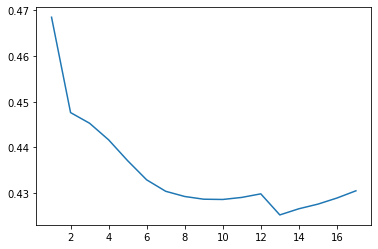

In [340]:
x = range(1,len(losses)+1)
sns.lineplot(x =x, y = list(map(float,losses)))


In [341]:
new_output = []
new_y = []
for i in range(len(outputs)):
    new_output.append(outputs[i].detach().numpy().squeeze())
    new_y.append(ys[i].numpy().squeeze())

new_output = np.array(new_output).reshape(-1)
new_y = np.array(new_y).reshape(-1)

array([0.4990589 , 1.3714486 , 1.4239254 , ..., 1.3714486 , 1.4239255 ,
       0.38636714], dtype=float32)

In [342]:
temp = pd.DataFrame(index = range(0,len(new_output)),data = {'output' : new_output, 'y' : new_y})
temp = temp.reset_index()

In [343]:
temp['diff'] = temp['y'] - temp['output']
temp['diff_abs'] = abs(temp['diff'])

## test결과에서 loss 크기 그래프

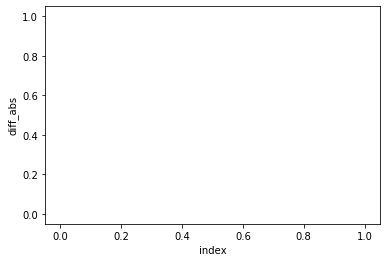

In [344]:
import seaborn as sns
sns.lineplot(data = temp,x = "index", y = 'diff_abs')

In [24]:
temp['diff_abs'].median()
#337.676072 * 0.27

0.26808493748012124

## MSE계산

In [30]:
from sklearn.metrics import mean_squared_error
ans = temp.loc[:len(data.loc[32477:])-1,'output'] *(data.loc[32477:,'pastBuyer_count_mean'].reset_index(drop = True))
mean_squared_error(test_y, ans )

405726.62758988887

448520.7540157402

In [345]:
past_buyer = data.loc[data.type == 'test','pastBuyer_count_mean_org']
ans =  (new_output[:len(past_buyer)] * past_buyer).reset_index(drop = True)

In [346]:
ans.to_csv("ans_without_mu.csv")